**Osservazioni/Dubbi:**  
- Ad ogni riavvio del kernel i risultati della loss prima e dopo il training variano (spesso anche di un'unità). Credo che questo sia dovuto al fatto che inizialmente i weights e biases siano impostati casualmente -> c'è un modo per ovviare questo "problema"
- I dati che ho per il training (85) sono "tanti o pochi" relativamente al mio task?
- Non capisco se la rete sta imparando e/o se va in overfitting
- Cosa fa esattamente il comando .view(-1)?

Ho trovato dei buoni parametri:  
- input_size = 2  
- hidden_size = 5  
- activation_fun = nn.Tanh()  
- learning_rate = 0.001  
- epochs = 1000  
- loss_fun = nn.MSELoss()  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import torch
from torch import autograd, nn
import torch.nn.functional as F
import torch.optim as optim
import functions as f
from tqdm import tqdm

In [2]:
data = pd.read_csv('data_fs.dat', delim_whitespace=True, decimal=",")

# ATTENZIONE!!! IN QUESTO CASO HO UN TRAIN_SET DI 113 ELEMENTI E UN TEST_SET DI 56
f.add_bool(data)

### Data_train

In [3]:
x = data["x"][data['check'] == True]
y = data["y"][data['check'] == True]

X_train = np.stack((x.values, y.values), axis=1)
X_train = torch.from_numpy(X_train).float()

y_train = data["e"][data['check'] == True]
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

#X_train, y_train

### Data_test

In [4]:
x = data["x"][data['check'] == False]
y = data["y"][data['check'] == False]

X_test = np.stack((x.values, y.values), axis=1)
X_test = torch.from_numpy(X_test).float()

y_test = data["e"][data['check'] == False]
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([85, 2]) torch.Size([85])
torch.Size([84, 2]) torch.Size([84])


### Set Parameters

In [5]:
input_size = 2
hidden_size = 5
activation_fun = nn.ReLU()
learning_rate = 0.001
epochs = 500
loss_fun = nn.MSELoss()

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.hidden = nn.Linear(input_size, hidden_size)
        self.activation = activation_fun
        self.output = nn.Linear(hidden_size, 1)
        
    def forward(self, input):
        hidden = self.hidden(input)
        activated = self.activation(hidden)
        output = self.output(activated)
        
        return output

In [7]:
net = Net()
opt = optim.Adam(net.parameters(), lr=learning_rate) #che valore di lr usare??

In [8]:
net.eval()

y_pred = net(X_test)
y_pred = torch.squeeze(y_pred)
before_train = loss_fun(y_pred, y_test)
print('Test loss before Training' , before_train.item())

Test loss before Training 0.37433019280433655


In [9]:
net.train()

training = []
validation = []

for epoch in tqdm(range(epochs)):
    opt.zero_grad()
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = loss_fun(y_train, y_pred)
    training.append(train_loss)
    
    
    with torch.no_grad():
        y_val = net(X_test)
        y_val = torch.squeeze(y_val)
        val_loss = loss_fun(y_val, y_test)
        assert val_loss.requires_grad == False
        validation.append(val_loss)
    
    
    #print('Epoch {}: train loss: {}'.format(epoch, train_loss.item()))
    train_loss.backward()
    opt.step()

100%|██████████| 500/500 [00:00<00:00, 707.52it/s]


In [10]:
net.eval()

y_pred = net(X_test)
y_pred = torch.squeeze(y_pred)
after_train = loss_fun(y_pred, y_test)
print('Test loss after Training' , after_train.item())

Test loss after Training 0.007452478166669607


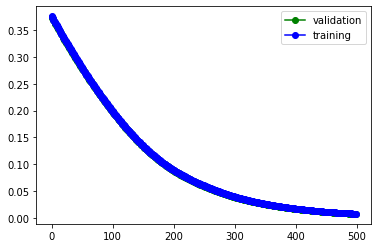

In [11]:
plt.plot(validation, marker='o', linestyle='-', color='green', label='validation')
plt.plot(training, marker='o', linestyle='-', color='blue', label='training')
plt.legend()

Text(0.5, 1.0, 'Error')

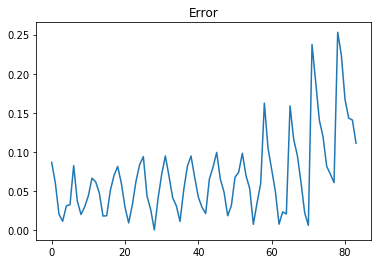

In [13]:
plt.plot(abs(net(X_test).view(-1) - y_test).detach().numpy())
plt.title('Error')